
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [4]:
import gym
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [29]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # nextQs calculated using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [30]:
# Generator: Generating the actions
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [31]:
def model_loss(states, actions, nextQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # Masking the actions logits
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [32]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [33]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. 
This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. 
Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. 
If you're unfamiliar with `deque`, this is a double-ended queue. 
You can think of it like a tube open on both sides. You can put objects in either side of the tube. 
But if it's full, adding anything more will push an object out the other side. 
This is a great data structure to use for the memory buffer.

In [34]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. 
We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  
That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. 
This is called an **$\epsilon$-greedy policy**.

At first, the agent needs to do a lot of exploring. 
Later when it has learned more, the agent can favor choosing actions based on what it has learned. 
This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, 
then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. 
We'll train the network in _episodes_. One *episode* is one simulation of the game. 
For this game, the goal is to keep the pole upright for 195 frames. 
So we can start a new episode once meeting that goal. 
The game ends if the pole tilts over too far, or if the cart moves too far the left or right. 
When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [35]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [36]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [37]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [38]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = [] # accuracy
q_loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            
            # Masking the nextQs using dones/end-of-episodes which defines the goal/task in this episode
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Updating the model: Calculating Qs using states and actions and Qt = rs/qs + (gamma * nextQs) 
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.nextQs: nextQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 1 Training q_loss: 0.0000 Explore P: 0.9999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 52 Training q_loss: 0.5170 Explore P: 0.9948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9 Training q_loss: 0.3383 Explore P: 0.9939
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 58 Training q_loss: 2.0469 Explore P: 0.9882
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Ep

-------------------------------------------------------------------------------
Episode: 36 Total reward: 41 Training q_loss: 30257.1992 Explore P: 0.9122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 17 Training q_loss: 30410.4629 Explore P: 0.9106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 17 Training q_loss: 40149.2188 Explore P: 0.9091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 30 Training q_loss: 103105.9297 Explore P: 0.9064
-------------------------------------------------------------------------------
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 71 Training q_loss: 80635368.0000 Explore P: 0.8248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 27 Training q_loss: 87060544.0000 Explore P: 0.8226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 15 Training q_loss: 161126272.0000 Explore P: 0.8214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 24 Training q_loss: 122134560.0000 Explore P: 0.8194
-------------------------------------------------------------------------------
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 108 Total reward: 9 Training q_loss: 13709476864.0000 Explore P: 0.7137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 44 Training q_loss: 16071202816.0000 Explore P: 0.7106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 25 Training q_loss: 30339045376.0000 Explore P: 0.7089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 111 Total reward: 104 Training q_loss: 11310539776.0000 Explore P: 0.7017
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 142 Total reward: 43 Training q_loss: 318650974208.0000 Explore P: 0.5645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 174 Training q_loss: 1786328383488.0000 Explore P: 0.5550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 245 Training q_loss: 1378377662464.0000 Explore P: 0.5418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 46 Training q_loss: 3210339155968.0000 Explore P: 0.5393
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 176 Total reward: 30 Training q_loss: 39833070206976.0000 Explore P: 0.3751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 348 Training q_loss: 35894522281984.0000 Explore P: 0.3626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 254 Training q_loss: 35945822814208.0000 Explore P: 0.3538
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 119 Training q_loss: 32123088011264.0000 Explore P: 0.3497
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 210 Total reward: 361 Training q_loss: 97165951107072.0000 Explore P: 0.1190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 256 Training q_loss: 134193879187456.0000 Explore P: 0.1162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 499 Training q_loss: 1311968224870400.0000 Explore P: 0.1111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 499 Training q_loss: 2497107944538112.0000 Explore P: 0.1061
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 244 Total reward: 284 Training q_loss: 32420747464933376.0000 Explore P: 0.0376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 324 Training q_loss: 31397132204244992.0000 Explore P: 0.0367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 271 Training q_loss: 16305004746899456.0000 Explore P: 0.0360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 391 Training q_loss: 23160931118743552.0000 Explore P: 0.0350
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 277 Total reward: 270 Training q_loss: 1243603313790812160.0000 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 499 Training q_loss: 1333442347312087040.0000 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 312 Training q_loss: 1873592965058789376.0000 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 477 Training q_loss: 2099880704392298496.0000 Explore P: 0.0172
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 310 Total reward: 499 Training q_loss: 13172841993081978880.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 499 Training q_loss: 14471468579578445824.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 499 Training q_loss: 9207818345368256512.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 499 Training q_loss: 7793857936920412160.0000 Explore P: 0.0115
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 343 Total reward: 499 Training q_loss: 14287765475344515072.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 499 Training q_loss: 10627901384315371520.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 499 Training q_loss: 21388346696335884288.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 499 Training q_loss: 16634090303669665792.0000 Explore P: 0.0103
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 376 Total reward: 499 Training q_loss: 20233896870566428672.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 377 Total reward: 499 Training q_loss: 19799167565129842688.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 378 Total reward: 499 Training q_loss: 15039472987952644096.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 379 Total reward: 499 Training q_loss: 22528177415502430208.0000 Explore P: 0.0101
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 409 Total reward: 499 Training q_loss: 55629263041745387520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 499 Training q_loss: 101611490226221350912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 499 Training q_loss: 103313287935413977088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 412 Total reward: 499 Training q_loss: 33708022641845075968.0000 Explore P: 0.0100
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 442 Total reward: 431 Training q_loss: 3824623709428121600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 443 Total reward: 336 Training q_loss: 46621039042167308288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 254 Training q_loss: 17846056682199711744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 240 Training q_loss: 65041271691507924992.0000 Explore P: 0.0100
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 477 Total reward: 11 Training q_loss: 672159839203360768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 478 Total reward: 12 Training q_loss: 17818280819458834432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 479 Total reward: 14 Training q_loss: 29314660050275401728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 480 Total reward: 12 Training q_loss: 12271384295305641984.0000 Explore P: 0.0100
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 510 Total reward: 14 Training q_loss: 3213274353663737856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 13 Training q_loss: 13390864153753681920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 512 Total reward: 11 Training q_loss: 10071412161218871296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 513 Total reward: 13 Training q_loss: 12310557695580045312.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 543 Total reward: 14 Training q_loss: 3253667387211251712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 544 Total reward: 17 Training q_loss: 1456583526454394880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 545 Total reward: 17 Training q_loss: 5463735511942168576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 546 Total reward: 13 Training q_loss: 1336269741462913024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 576 Total reward: 499 Training q_loss: 6369224019345932288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 577 Total reward: 499 Training q_loss: 12532411654274547712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 499 Training q_loss: 14801403431771701248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 499 Training q_loss: 11963197783109795840.0000 Explore P: 0.0100
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 611 Total reward: 13 Training q_loss: 15484512413922885632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 612 Total reward: 9 Training q_loss: 15600314078071881728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 12 Training q_loss: 8252719873319239680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 9 Training q_loss: 4514368794008748032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 644 Total reward: 10 Training q_loss: 36656785284191485952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 645 Total reward: 10 Training q_loss: 42013381634344091648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 646 Total reward: 11 Training q_loss: 51344272714255826944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 647 Total reward: 8 Training q_loss: 25667302904012210176.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 679 Total reward: 11 Training q_loss: 26039513978293452800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 680 Total reward: 8 Training q_loss: 22477204056438734848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 681 Total reward: 10 Training q_loss: 15171218670216019968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 682 Total reward: 11 Training q_loss: 43497379284213825536.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 714 Total reward: 12 Training q_loss: 34647146309454135296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 715 Total reward: 12 Training q_loss: 1281482726318276608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 9 Training q_loss: 40434579693880999936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 11 Training q_loss: 15876356367829696512.0000 Explore P: 0.0100
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 749 Total reward: 10 Training q_loss: 27868800060726706176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 750 Total reward: 15 Training q_loss: 64510489050268827648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 751 Total reward: 14 Training q_loss: 45309735086602584064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 15 Training q_loss: 35811894161129340928.0000 Explore P: 0.0100
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 782 Total reward: 111 Training q_loss: 85717301978812383232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 783 Total reward: 108 Training q_loss: 75199250602204856320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 107 Training q_loss: 76549758744369561600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 785 Total reward: 24 Training q_loss: 31627269454046429184.0000 Explore P: 0.0100
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 815 Total reward: 21 Training q_loss: 45501850554300628992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 816 Total reward: 20 Training q_loss: 75560620491836227584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 14 Training q_loss: 55423152990049009664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 18 Training q_loss: 23394141778422530048.0000 Explore P: 0.0100
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 849 Total reward: 14 Training q_loss: 52220341589035188224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 18 Training q_loss: 83779689811787382784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 14 Training q_loss: 53428467373449412608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 852 Total reward: 17 Training q_loss: 184939403904295108608.0000 Explore P: 0.0100
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 883 Total reward: 15 Training q_loss: 66625707529551740928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 13 Training q_loss: 87797067805169287168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 885 Total reward: 14 Training q_loss: 30963696594497568768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 886 Total reward: 18 Training q_loss: 50552839846536151040.0000 Explore P: 0.0100
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 917 Total reward: 20 Training q_loss: 107413067728227926016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 918 Total reward: 19 Training q_loss: 25665543685407768576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 919 Total reward: 16 Training q_loss: 25961039634395824128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 920 Total reward: 18 Training q_loss: 49561647706282131456.0000 Explore P: 0.0100
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 951 Total reward: 98 Training q_loss: 50633447242991665152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 952 Total reward: 100 Training q_loss: 111538347394713255936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 953 Total reward: 101 Training q_loss: 203180970312168636416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 954 Total reward: 103 Training q_loss: 36108052016117317632.0000 Explore P: 0.0100
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 984 Total reward: 499 Training q_loss: 138204846883629694976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 985 Total reward: 499 Training q_loss: 103808244089773621248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 986 Total reward: 499 Training q_loss: 181239591257293979648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 987 Total reward: 499 Training q_loss: 102303487660371476480.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1017 Total reward: 499 Training q_loss: 163306820491058085888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1018 Total reward: 499 Training q_loss: 174632564313336840192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1019 Total reward: 499 Training q_loss: 159629912870286786560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1020 Total reward: 499 Training q_loss: 117481999391214534656.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1050 Total reward: 499 Training q_loss: 314894852539233075200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1051 Total reward: 499 Training q_loss: 346732557523719553024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1052 Total reward: 499 Training q_loss: 594273614729580642304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1053 Total reward: 499 Training q_loss: 1062690056485130469376.0000 Explore P: 0.0100
---------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1083 Total reward: 499 Training q_loss: 222964227944044560384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1084 Total reward: 499 Training q_loss: 264657022774054748160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1085 Total reward: 499 Training q_loss: 752373535179584569344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1086 Total reward: 499 Training q_loss: 174481711318005972992.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1116 Total reward: 499 Training q_loss: 516439309744619913216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1117 Total reward: 499 Training q_loss: 537559186487778476032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1118 Total reward: 499 Training q_loss: 629215073913511346176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1119 Total reward: 499 Training q_loss: 901393495093367799808.0000 Explore P: 0.0100
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1149 Total reward: 499 Training q_loss: 183137365919021400064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1150 Total reward: 499 Training q_loss: 13105966397345759232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1151 Total reward: 499 Training q_loss: 179165366969541066752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1152 Total reward: 499 Training q_loss: 38112798164111065088.0000 Explore P: 0.0100
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1182 Total reward: 499 Training q_loss: 156274962045337600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1183 Total reward: 499 Training q_loss: 80959609612309364736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1184 Total reward: 499 Training q_loss: 29957834770105761792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1185 Total reward: 499 Training q_loss: 176433820545843200.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1215 Total reward: 499 Training q_loss: 54090285412440342528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1216 Total reward: 499 Training q_loss: 247314902782312448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1217 Total reward: 499 Training q_loss: 35746114778486013952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1218 Total reward: 499 Training q_loss: 204716180190003200.0000 Explore P: 0.0100
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1248 Total reward: 499 Training q_loss: 48772413861818007552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1249 Total reward: 499 Training q_loss: 106350262196633600000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1250 Total reward: 499 Training q_loss: 18513706530864365568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1251 Total reward: 499 Training q_loss: 7564483318691921920.0000 Explore P: 0.0100
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1281 Total reward: 499 Training q_loss: 1675664446454902030336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1282 Total reward: 499 Training q_loss: 2563732634675810664448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1283 Total reward: 499 Training q_loss: 2298641894147016884224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1284 Total reward: 499 Training q_loss: 2106968412531151863808.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1314 Total reward: 499 Training q_loss: 8361310447632071524352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward: 499 Training q_loss: 9814158739572864843776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1316 Total reward: 499 Training q_loss: 11213133283921192026112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1317 Total reward: 499 Training q_loss: 11473308486194199265280.0000 Explore P: 0.0100
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1347 Total reward: 499 Training q_loss: 10968638489650782011392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 499 Training q_loss: 10573175154571565072384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 499 Training q_loss: 10111426714276802330624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1350 Total reward: 499 Training q_loss: 8907056650476828229632.0000 Explore P: 0.0100
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1380 Total reward: 499 Training q_loss: 9650716353696148488192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1381 Total reward: 499 Training q_loss: 11009819404643457826816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1382 Total reward: 499 Training q_loss: 10582021350139627569152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1383 Total reward: 499 Training q_loss: 12861754740513641070592.0000 Explore P: 0.0100
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1413 Total reward: 499 Training q_loss: 10248095200368801087488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1414 Total reward: 499 Training q_loss: 8935342633836435472384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1415 Total reward: 499 Training q_loss: 6488259421959008288768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1416 Total reward: 499 Training q_loss: 10266072444181357264896.0000 Explore P: 0.0100
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1446 Total reward: 499 Training q_loss: 6659241959511849697280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1447 Total reward: 499 Training q_loss: 5471802052611068133376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1448 Total reward: 499 Training q_loss: 6330501704711940341760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1449 Total reward: 499 Training q_loss: 6167155020327305609216.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1479 Total reward: 499 Training q_loss: 3910600531335461208064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1480 Total reward: 499 Training q_loss: 4326212971147533746176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1481 Total reward: 499 Training q_loss: 3580275290941694148608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1482 Total reward: 499 Training q_loss: 3262817116158301306880.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1512 Total reward: 499 Training q_loss: 2703225722159100854272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1513 Total reward: 499 Training q_loss: 2785209249775753363456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1514 Total reward: 499 Training q_loss: 3139024702875931508736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1515 Total reward: 499 Training q_loss: 3750967909268523581440.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1545 Total reward: 499 Training q_loss: 2958593050354913378304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1546 Total reward: 499 Training q_loss: 2960525094595055321088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1547 Total reward: 499 Training q_loss: 3357956784186409877504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1548 Total reward: 499 Training q_loss: 2825436246072356765696.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1578 Total reward: 499 Training q_loss: 2656525082873129074688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 499 Training q_loss: 2669596780791571939328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 499 Training q_loss: 2853148301954450980864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1581 Total reward: 499 Training q_loss: 2686085866402258878464.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1611 Total reward: 499 Training q_loss: 3179219892500166606848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1612 Total reward: 499 Training q_loss: 3317064099569885773824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1613 Total reward: 499 Training q_loss: 2723875570875524710400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1614 Total reward: 499 Training q_loss: 2636612417120710426624.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1644 Total reward: 499 Training q_loss: 2943046061491277004800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1645 Total reward: 499 Training q_loss: 3217128379413604335616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1646 Total reward: 499 Training q_loss: 3118994099108271095808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1647 Total reward: 499 Training q_loss: 2924016382740799684608.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1677 Total reward: 499 Training q_loss: 2872919948743537590272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1678 Total reward: 499 Training q_loss: 3014291881696371408896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1679 Total reward: 499 Training q_loss: 2764839187186179899392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1680 Total reward: 499 Training q_loss: 2913660355397661229056.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1710 Total reward: 499 Training q_loss: 3307284251504074031104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1711 Total reward: 499 Training q_loss: 2811433991880908472320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1712 Total reward: 499 Training q_loss: 3099574577515049517056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1713 Total reward: 499 Training q_loss: 3068970366247253311488.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1743 Total reward: 499 Training q_loss: 3119646276629309685760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1744 Total reward: 499 Training q_loss: 2443448244028185772032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1745 Total reward: 499 Training q_loss: 2778762628384149209088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1746 Total reward: 499 Training q_loss: 3058264465508063510528.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1776 Total reward: 499 Training q_loss: 3046060836417796308992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1777 Total reward: 499 Training q_loss: 2896432397973108817920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1778 Total reward: 499 Training q_loss: 2805678673032105689088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1779 Total reward: 499 Training q_loss: 2897512135983770894336.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1809 Total reward: 499 Training q_loss: 2894265603602390188032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1810 Total reward: 499 Training q_loss: 3336417474543580348416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1811 Total reward: 499 Training q_loss: 3348946488706925068288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1812 Total reward: 499 Training q_loss: 3537595521698034089984.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1842 Total reward: 499 Training q_loss: 3284131808769715732480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 499 Training q_loss: 2977323521205147271168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 499 Training q_loss: 3307115085043070926848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 499 Training q_loss: 3156620548095044747264.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1875 Total reward: 499 Training q_loss: 3034464911802247413760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1876 Total reward: 499 Training q_loss: 2814386382911626543104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 499 Training q_loss: 2699966804878744879104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1878 Total reward: 499 Training q_loss: 2914081441962820370432.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1908 Total reward: 499 Training q_loss: 2764825957862274498560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1909 Total reward: 499 Training q_loss: 2443709171331596550144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1910 Total reward: 499 Training q_loss: 2461951564572214165504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 499 Training q_loss: 2736199671255824072704.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1941 Total reward: 499 Training q_loss: 3089828787921419763712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1942 Total reward: 499 Training q_loss: 2552763836308373110784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1943 Total reward: 499 Training q_loss: 2857262058739077218304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 499 Training q_loss: 3114451655934114529280.0000 Explore P: 0.0100
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1974 Total reward: 499 Training q_loss: 2789410826753113325568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1975 Total reward: 499 Training q_loss: 2515295576258510848000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1976 Total reward: 499 Training q_loss: 2842150511664412229632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1977 Total reward: 499 Training q_loss: 3054378703454572904448.0000 Explore P: 0.0100
------------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

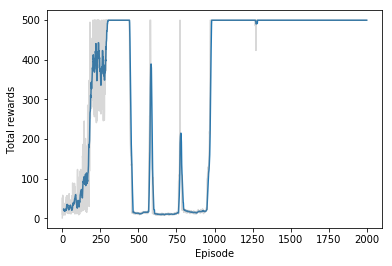

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

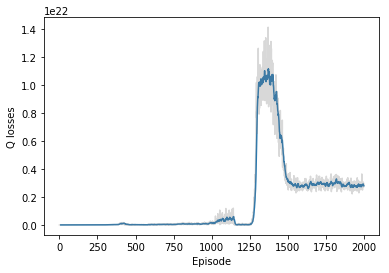

In [26]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, _, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [39]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.